
# ANALYZING THE SAKILA DATABASE

### Creating a connection to the database

In [1]:
# importing the needed libraries
from dotenv import load_dotenv
import os
import pandas as pd
from sqlalchemy import create_engine

# Using the load_dotenv() function to get the text file housing our environment variables
load_dotenv('sakila_cred.txt')

# Using the getenv method to secretly get credentials from the text file and assign them the appropriate variable names
username = os.getenv('USERNAME1')
host = os.getenv('HOST')
password = os.getenv('PASSWORD')
database_name = os.getenv('DATABASE_NAME')

# Finally creating a connection
connection = create_engine(f'mysql+mysqlconnector://{username}:{password}@{host}/{database_name}')
print('CONNECTION SUCCESSFULLY CREATED')

CONNECTION SUCCESSFULLY CREATED


#### Showing the tables in the database

In [3]:
db_query = '''
               SHOW TABLES
            '''

# read tables in sakila into pandas dataframe
sakila_tables = pd.read_sql(db_query, connection)

# print it out
sakila_tables

,Tables_in_sakila
0,actor
1,actor_info
2,address
3,category
4,city
5,country
6,customer
7,customer_list
8,film
9,film_actor


#### 1. Determine how much we made in revenue from active and inactive members. Visualize the result as a bar chart

In [2]:
# Read in 'customer_id', 'active' and 'amount' column after inner joining the 'customer' and 'payment' tables
# First assign the sql query to a variable db_query
db_query = '''
               SELECT c.customer_id, 
                           c.active,
                            p.amount
               FROM customer c
               INNER JOIN payment p
               USING (customer_id);
            '''

# Read the outcome of the sql query into pandas dataframe and assign it a variable cust_status_pay
cust_status_pay = pd.read_sql(db_query, connection)

# print it out
cust_status_pay

,customer_id,active,amount
0,1,1,2.99
1,1,1,0.99
2,1,1,5.99
3,1,1,0.99
4,1,1,9.99
...,...,...,...
16039,599,1,4.99
16040,599,1,1.99
16041,599,1,8.99
16042,599,1,2.99


In [18]:
# Inserting a 'customer_status' column based on value in the 'active' column
cust_status_pay['customer_status'] = cust_status_pay['active'].replace(1, 'active').replace(0, 'inactive')
cust_status_pay

,customer_id,active,amount,customer_status
0,1,1,2.99,active
1,1,1,0.99,active
2,1,1,5.99,active
3,1,1,0.99,active
4,1,1,9.99,active
...,...,...,...,...
16039,599,1,4.99,active
16040,599,1,1.99,active
16041,599,1,8.99,active
16042,599,1,2.99,active


In [19]:
# Finding revenue generated from active and inactive customers
revenue_status = cust_status_pay.groupby('customer_status')['amount'].sum()
revenue_status

customer_status
active      65746.60
inactive     1659.96
Name: amount, dtype: float64

In [21]:
print(f'''
          We made a revenue of {revenue_status['active']:,.2f} from active customers
          and {revenue_status['inactive']:,.2f} from inactive customers
      ''')


          We made a revenue of 65,746.60 from active customers
          and 1,659.96 from inactive customers
      


<Axes: title={'center': 'REVENUE BY CUSTOMER STATUS'}, xlabel='customer_status'>

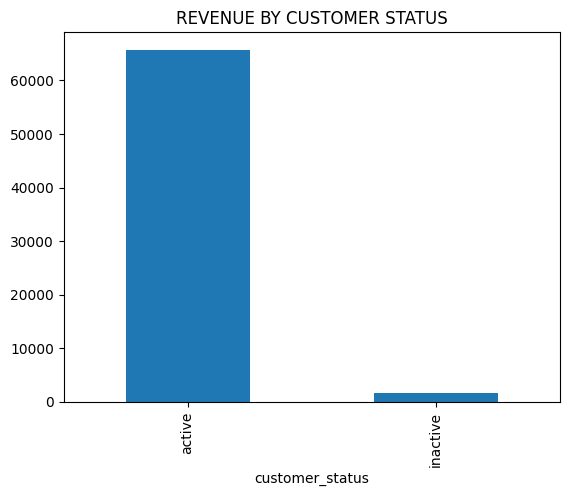

In [20]:
# Plotting a bar graph for revenue_status
revenue_status.plot.bar(title = 'REVENUE BY CUSTOMER STATUS')

### 2. We have 2 staff members, Mike and Jon. Determine the staff member that contributed the most to our revenue. Visualize their percentage contribution as a pie chart.

In our sql query, we join two tables 'staff' and 'payment' and select only our needed fields from the joined table with appriopriate aliases

In [22]:
db_query = '''
            SELECT s.staff_id, 
                   s.first_name as staff_name,
                   p.amount as revenue
            FROM staff s
            INNER JOIN payment p
            USING (staff_id);
            
            '''

# read in the output of the sql query into pandas dataframe and assign it a variable 'staff_revenue'
staff_revenue = pd.read_sql(db_query, connection)
staff_revenue

,staff_id,staff_name,revenue
0,1,Mike,2.99
1,1,Mike,0.99
2,1,Mike,5.99
3,1,Mike,4.99
4,1,Mike,4.99
...,...,...,...
16039,2,Jon,2.99
16040,2,Jon,3.99
16041,2,Jon,8.99
16042,2,Jon,2.99


In [24]:
# Finding revenue generated by staff members Mike and Jon
sr = staff_revenue.groupby('staff_name')['revenue'].sum()
sr

staff_name
Jon     33924.06
Mike    33482.50
Name: revenue, dtype: float64

<Axes: title={'center': 'REVENUE GENERATED BY STAFF MEMBERS'}, ylabel='revenue'>

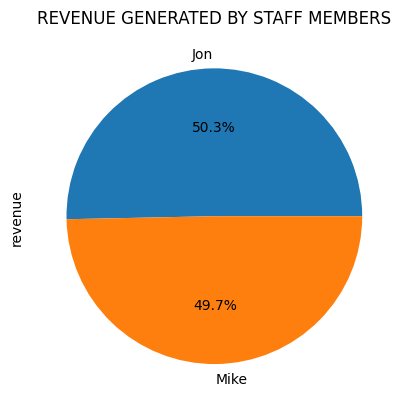

In [27]:
# plotting it on a pie chart
sr.plot.pie(title = 'REVENUE GENERATED BY STAFF MEMBERS', autopct = '%.1f%%')

Jon contributed 50.3% of the total revenue, narrowly beating Mike who contributed 49.7% of the total revenue 

### 3. Create a simple line chart showing the monthly rental count of the store

In [44]:
# assign the appriopriate sql query to a variable
db_query = '''
            SELECT count(rental_id) as number_of_rentals,
                                             rental_date
            FROM rental
            GROUP BY rental_date;
           '''
# read in the output of the query into pandas dataframe and parse in the 'rental_date' field as a datetime object
rental_df = pd.read_sql(db_query, connection, parse_dates = ['rental_date'])
rental_df

,number_of_rentals,rental_date
0,1,2005-05-24 22:53:30
1,1,2005-05-24 22:54:33
2,1,2005-05-24 23:03:39
3,1,2005-05-24 23:04:41
4,1,2005-05-24 23:05:21
...,...,...
15810,1,2005-08-23 22:26:47
15811,1,2005-08-23 22:42:48
15812,1,2005-08-23 22:43:07
15813,1,2005-08-23 22:50:12


In [45]:
# Check to confirm if the 'rental_date' field was successfully parsed in as datetime object
rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15815 entries, 0 to 15814
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   number_of_rentals  15815 non-null  int64         
 1   rental_date        15815 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 247.2 KB


In [46]:
import datetime
# Insert a 'rental_month' column by extracting the year and month from 'rental_date'
rental_df['rental_month'] = rental_df['rental_date'].dt.strftime('%Y-%m')
rental_df

,number_of_rentals,rental_date,rental_month
0,1,2005-05-24 22:53:30,2005-05
1,1,2005-05-24 22:54:33,2005-05
2,1,2005-05-24 23:03:39,2005-05
3,1,2005-05-24 23:04:41,2005-05
4,1,2005-05-24 23:05:21,2005-05
...,...,...,...
15810,1,2005-08-23 22:26:47,2005-08
15811,1,2005-08-23 22:42:48,2005-08
15812,1,2005-08-23 22:43:07,2005-08
15813,1,2005-08-23 22:50:12,2005-08


In [47]:
# Calculate rental by month
RentalByMonth = rental_df.groupby('rental_month')['number_of_rentals'].sum()
RentalByMonth

rental_month
2005-05    1156
2005-06    2311
2005-07    6709
2005-08    5686
2006-02     182
Name: number_of_rentals, dtype: int64

<Axes: title={'center': 'RENTALS BY MONTH'}, xlabel='rental_month'>

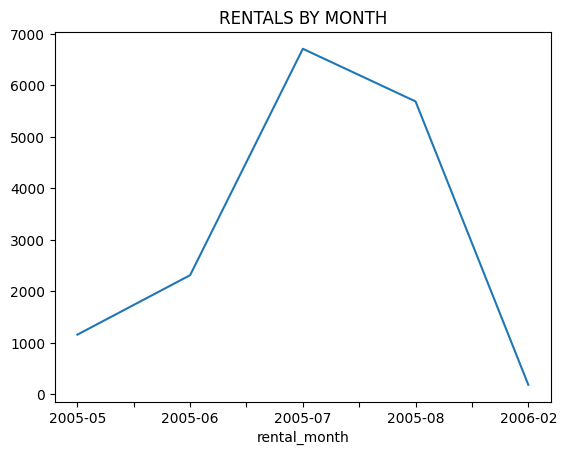

In [54]:
# Plotting rental by month
RentalByMonth.plot(title = 'RENTALS BY MONTH')

The number of rentals peaked in July 2005 with 6,709 rentals made in that month but dropped drastically to only 182 rentals in February 2006.

### 4. Create a basic bar chart to show the monthly revenue for the rental store

To get the monthly by revenue, first we have to find a way to join 'store' table and 'payment' table as those are the tables that contains our fields of interest (store_id, amount, payment_date).In the sakila database, these two tables doesn't share a common field/column so we join them through the 'staff' table.

In [65]:
# assign our sql query to a variable 
db_query = '''
              SELECT s.store_id,
                       p.amount,
                       p.payment_date
              FROM store s INNER JOIN staff USING (store_id)
                           INNER JOIN payment p USING (staff_id);
           '''

# read the output of the sql query into pandas dataframe and assign it to 'store_pay'
store_pay = pd.read_sql(db_query, connection, parse_dates = ['payment_date'])
store_pay

,store_id,amount,payment_date
0,1,2.99,2005-05-25 11:30:37
1,1,0.99,2005-05-28 10:35:23
2,1,5.99,2005-06-15 00:54:12
3,1,4.99,2005-06-16 15:18:57
4,1,4.99,2005-06-18 08:41:48
...,...,...,...
16039,2,2.99,2005-07-31 06:41:19
16040,2,3.99,2005-08-17 00:05:05
16041,2,8.99,2005-08-23 06:09:44
16042,2,2.99,2005-08-23 11:08:46


In [66]:
# Insert a payment month column
store_pay['payment_month'] = store_pay['payment_date'].dt.strftime('%Y-%m')
store_pay

,store_id,amount,payment_date,payment_month
0,1,2.99,2005-05-25 11:30:37,2005-05
1,1,0.99,2005-05-28 10:35:23,2005-05
2,1,5.99,2005-06-15 00:54:12,2005-06
3,1,4.99,2005-06-16 15:18:57,2005-06
4,1,4.99,2005-06-18 08:41:48,2005-06
...,...,...,...,...
16039,2,2.99,2005-07-31 06:41:19,2005-07
16040,2,3.99,2005-08-17 00:05:05,2005-08
16041,2,8.99,2005-08-23 06:09:44,2005-08
16042,2,2.99,2005-08-23 11:08:46,2005-08


In [78]:
# Find revenue by store for each month
# sum the 'amount' column and group by both store_id and payment month
StoreMonthlyRev = store_pay.groupby(['store_id', 'payment_month'])['amount'].sum()

# convert to pandas dataframe
StoreMonthlyRev = pd.DataFrame(StoreMonthlyRev)
StoreMonthlyRev

amount
store_id payment_month          
1        2005-05         2621.83
         2005-06         4774.37
         2005-07        13998.56
         2005-08        11853.65
         2006-02          234.09
2        2005-05         2201.61
         2005-06         4855.52
         2005-07        14370.35
         2005-08        12216.49
         2006-02          280.09

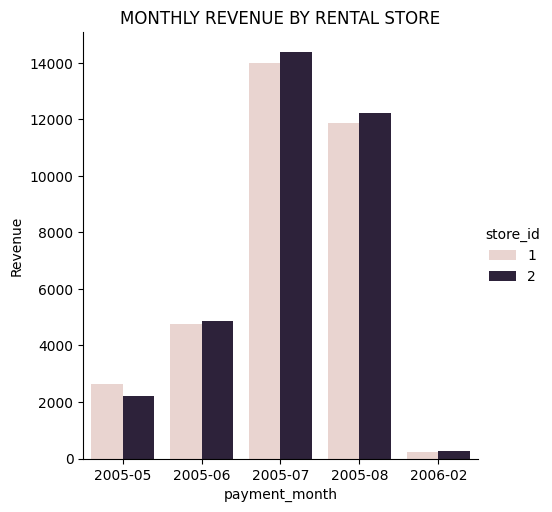

In [81]:
# Import seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# use seaborn's category plot to plot a clustered bar graph
sns.catplot(data=StoreMonthlyRev, kind="bar", x="payment_month", y="amount", hue="store_id")
plt.ylabel('Revenue')
plt.title('MONTHLY REVENUE BY RENTAL STORE')
plt.show()